In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, precision_score,classification_report
from sklearn.model_selection import ParameterGrid
import os

In [2]:
df_cont = pd.read_csv("C:/Users/sehsa/Downloads/df_continous.csv")
df_cont.drop("Close", axis=1, inplace=True)
df_cont.head()

,Target,btc_dom,sma_2,sma_3,sma_4,sma_5,sma_6,sma_8,sma_12,sma_16,...,cci_6,cci_8,cci_12,ado,eth_MACD,eth_MACD_signal,eth_MACD_hist,eth_STOCHk_14_3_3,eth_STOCHd_14_3_3,eth_Williams_%R
0,0,54.39109,296.530,296.4225,296.750000,295.930,295.565000,293.94500,294.156667,296.180625,...,2.875399,32.319410,22.875017,493.378047,-2.627344,-2.940150,0.312807,53.412335,49.021066,-51.867220
1,1,54.39109,292.545,295.5300,294.976667,295.512,295.253333,293.94500,293.545000,295.143125,...,-71.052007,-2.230640,2.851062,450.385447,-2.752230,-2.902566,0.150336,52.045861,52.196828,-53.814793
2,0,54.39109,292.550,294.5400,292.773333,295.070,295.131667,294.81125,293.353333,294.518750,...,-35.178876,11.882980,46.039872,427.232234,-2.710221,-2.864097,0.153876,49.474662,51.644286,-45.894001
3,1,54.39109,291.125,291.8350,291.373333,293.436,294.061667,294.22125,293.292500,293.925000,...,-144.128788,-141.125863,-61.206078,382.210034,-2.982263,-2.887730,-0.094533,44.040260,48.520261,-68.170426
4,0,54.39109,289.590,291.0700,290.803333,291.500,292.890000,293.74625,292.986667,293.385000,...,-116.912347,-143.861874,-87.968012,407.012559,-3.070475,-2.924279,-0.146196,41.636001,45.050308,-61.027569


In [3]:
split_index = int(len(df_cont) * 0.8)  # %80 train, %20 test
data_training = df_cont.loc[:split_index - 1, :].copy()   #  %80
data_testing = df_cont.loc[split_index:, :].copy()  #  %20


feature_columns = df_cont.columns.drop('Target')  # 'Target' dışındaki sütunlar özellik
X_train = data_training[feature_columns].values  # Eğitim verisi özellikleri
y_train = data_training['Target'].values  # Eğitim verisi hedef değişkeni
X_test = data_testing[feature_columns].values  # Test verisi özellikleri
y_test = data_testing['Target'].values  # Test verisi hedef değişkeni

# MinMaxScaler ile ölçeklendirme
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

validation_size = int(len(X_train_scaled) * 0.1)  # Eğitim verisinin %10'u doğrulama için
X_val_scaled = X_train_scaled[-validation_size:]  # Son %10 doğrulama verisi
y_val = y_train[-validation_size:]  # Son %10 hedef değişken
X_train_scaled = X_train_scaled[:-validation_size]  # İlk %90 eğitim verisi
y_train = y_train[:-validation_size]  # İlk %90 hedef değişken

# Zaman serisi formatına dönüştürme
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)

# Zaman penceresi boyutu
window_size = 5

# Eğitim ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, window_size)


In [32]:
X_train_seq.shape, y_train_seq.shape,X_test_seq.shape,y_test_seq.shape,X_val_seq.shape,y_val_seq.shape

((36359, 10, 44), (36359,), (10093, 10, 44), (10093,), (4031, 10, 44), (4031,))

In [14]:
# Model oluşturma
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

# Compiling the model
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


569/569 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5061 - loss: 0.6932 - val_accuracy: 0.5012 - val_loss: 0.6932
Epoch 2/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5101 - loss: 0.6931 - val_accuracy: 0.5062 - val_loss: 0.6937
Epoch 3/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5105 - loss: 0.6929 - val_accuracy: 0.5062 - val_loss: 0.6933
Epoch 4/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5107 - loss: 0.6932 - val_accuracy: 0.5062 - val_loss: 0.6931
Epoch 5/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5095 - loss: 0.6929 - val_accuracy: 0.5154 - val_loss: 0.6928
Epoch 6/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5143 - loss: 0.6925 - val_accuracy: 0.5062 - val_loss: 0.6934
Epoch 7/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5174 - loss: 0.6924 - val_accuracy: 0.5062 - val_loss: 0.6947
Epoch 8/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5123 - loss: 0.6926 - val_accuracy: 0.5

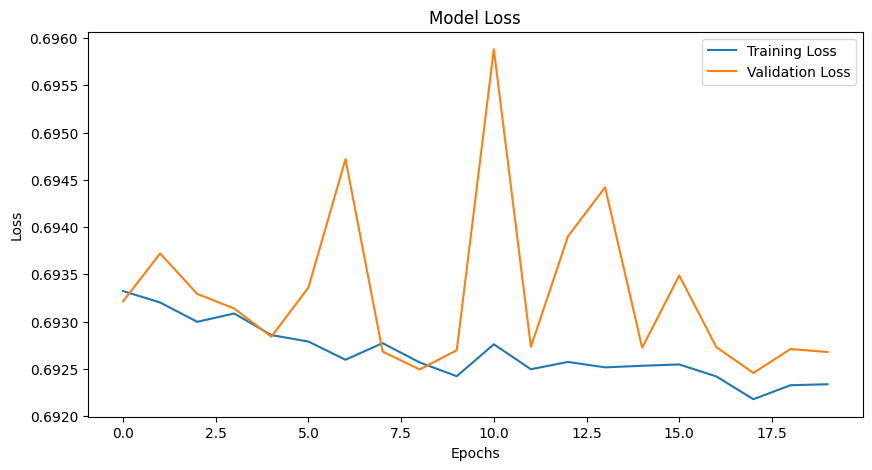

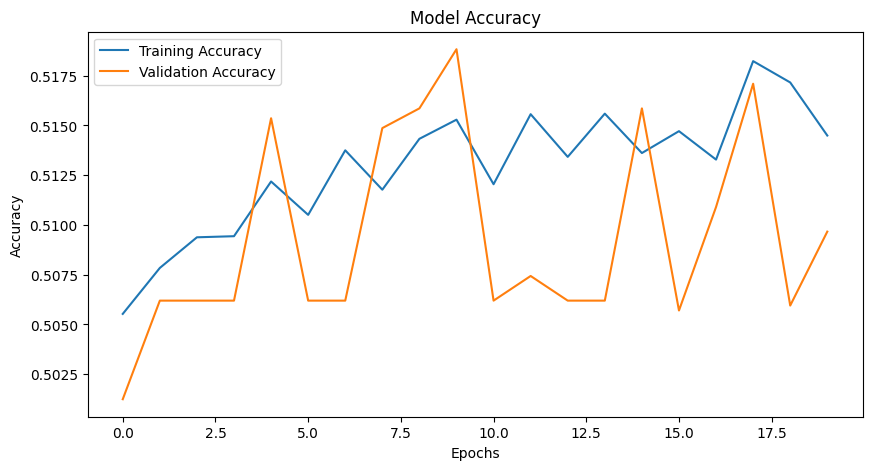

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.5132
              precision    recall  f1-score   support

           0       0.56      0.18      0.27      5122
           1       0.50      0.86      0.64      4976

    accuracy                           0.51     10098
   macro avg       0.53      0.52      0.45     10098
weighted avg       0.53      0.51      0.45     10098

ROC-AUC Score: 0.5356


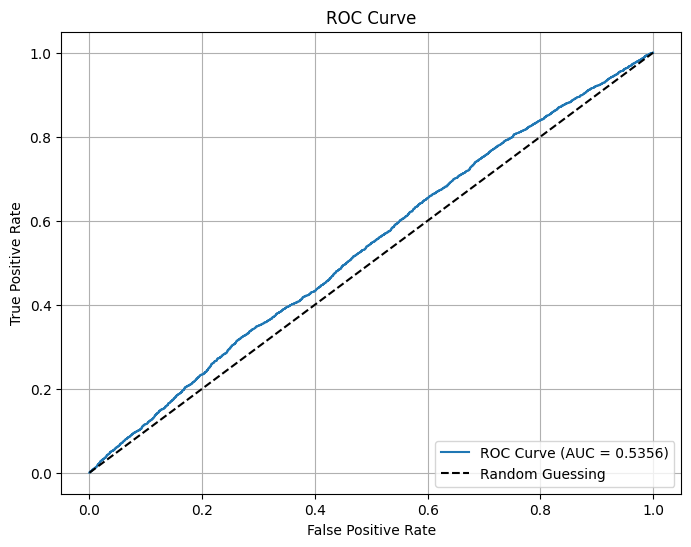

In [15]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
568/568 ━━━━━━━━━━━━━━━━━━━━ 125s 213ms/step - accuracy: 0.5022 - loss: 0.6943 - val_accuracy: 0.4961 - val_loss: 0.6931
Epoch 2/150
568/568 ━━━━━━━━━━━━━━━━━━━━ 111s 195ms/step - accuracy: 0.5006 - loss: 0.6938 - val_accuracy: 0.5066 - val_loss: 0.7003
Epoch 3/150
568/568 ━━━━━━━━━━━━━━━━━━━━ 109s 191ms/step - accuracy: 0.5018 - loss: 0.6934 - val_accuracy: 0.5066 - val_loss: 0.6936
Epoch 4/150
568/568 ━━━━━━━━━━━━━━━━━━━━ 106s 186ms/step - accuracy: 0.5117 - loss: 0.6930 - val_accuracy: 0.5066 - val_loss: 0.7002
Epoch 5/150
568/568 ━━━━━━━━━━━━━━━━━━━━ 110s 193ms/step - accuracy: 0.5155 - loss: 0.6928 - val_accuracy: 0.5066 - val_loss: 0.6958
Epoch 6/150
568/568 ━━━━━━━━━━━━━━━━━━━━ 115s 202ms/step - accuracy: 0.5065 - loss: 0.6930 - val_accuracy: 0.5066 - val_loss: 0.6961
Epoch 7/150
568/568 ━━━━━━━━━━━━━━━━━━━━ 117s 205ms/step - accuracy: 0.5126 - loss: 0.6928 - val_accuracy: 0.5066 - val_loss: 0.6961
Epoch 8/150
568/568 ━━━━━━━━━━━━━━━━━━━━ 119s 209ms/step - accuracy: 

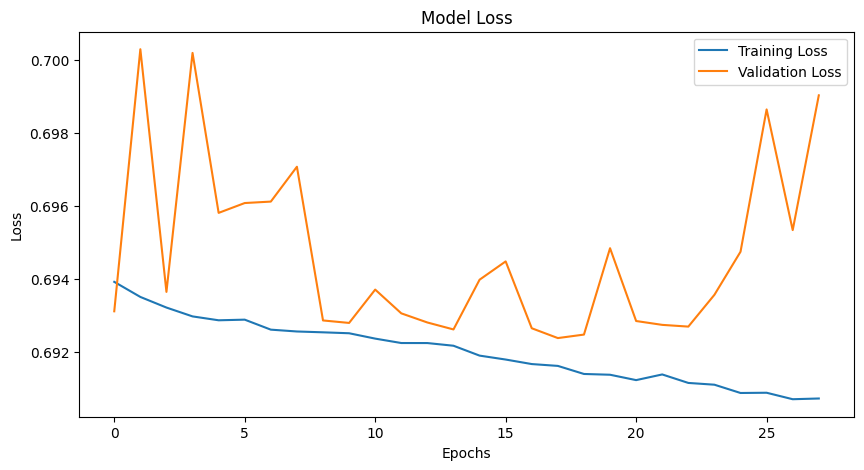

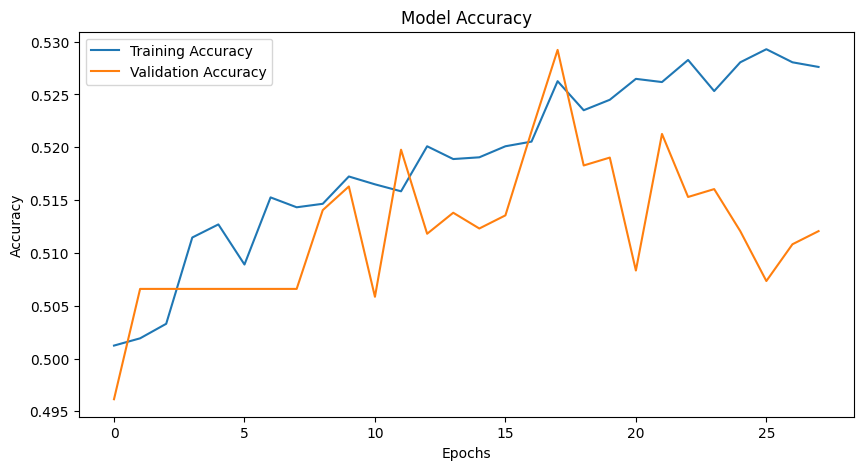

316/316 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Accuracy: 0.5179
              precision    recall  f1-score   support

           0       0.54      0.30      0.39      5112
           1       0.51      0.74      0.60      4971

    accuracy                           0.52     10083
   macro avg       0.53      0.52      0.50     10083
weighted avg       0.53      0.52      0.49     10083

ROC-AUC Score: 0.5388


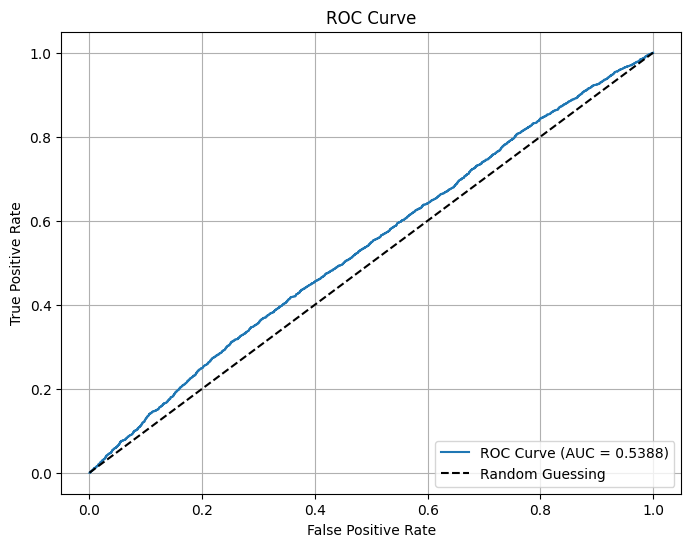

In [78]:
# Zaman penceresi boyutu
window_size = 20

# Eğitim ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, window_size)

# Model oluşturma
model = Sequential()
model.add(LSTM(500, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(500, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(500, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

# Compiling the model
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# LSTM modelinizin tahminleri (örnek)
# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Modeli kaydetme
model.save('model3.keras')


In [6]:
n = len(df_cont)
df = df_cont.iloc[:n//2]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25256 entries, 0 to 25255
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Target             25256 non-null  int64  
 1   btc_dom            25256 non-null  float64
 2   sma_2              25256 non-null  float64
 3   sma_3              25256 non-null  float64
 4   sma_4              25256 non-null  float64
 5   sma_5              25256 non-null  float64
 6   sma_6              25256 non-null  float64
 7   sma_8              25256 non-null  float64
 8   sma_12             25256 non-null  float64
 9   sma_16             25256 non-null  float64
 10  sma_24             25256 non-null  float64
 11  sma_10             25256 non-null  float64
 12  sma_48             25256 non-null  float64
 13  ema_2              25256 non-null  float64
 14  ema_3              25256 non-null  float64
 15  ema_4              25256 non-null  float64
 16  ema_6              252

In [8]:
split_index = int(len(df) * 0.8)  # %80 train, %20 test
data_training_df = df.loc[:split_index - 1, :].copy()   #  %80
data_testing_df = df.loc[split_index:, :].copy()  #  %20


feature_columns = df.columns.drop('Target')  # 'Target' dışındaki sütunlar özellik
X_train_df = data_training_df[feature_columns].values  # Eğitim verisi özellikleri
y_train_df = data_training_df['Target'].values  # Eğitim verisi hedef değişkeni
X_test_df = data_testing_df[feature_columns].values  # Test verisi özellikleri
y_test_df = data_testing_df['Target'].values  # Test verisi hedef değişkeni

# MinMaxScaler ile ölçeklendirme
scaler = MinMaxScaler()
X_train_scaled_df = scaler.fit_transform(X_train_df)
X_test_scaled_df = scaler.transform(X_test_df)

validation_size = int(len(X_train_scaled_df) * 0.1)  # Eğitim verisinin %10'u doğrulama için
X_val_scaled_df = X_train_scaled_df[-validation_size:]  # Son %10 doğrulama verisi
y_val_df = y_train_df[-validation_size:]  # Son %10 hedef değişken
X_train_scaled_df = X_train_scaled_df[:-validation_size]  # İlk %90 eğitim verisi
y_train_df = y_train_df[:-validation_size]  # İlk %90 hedef değişken


In [9]:
X_train_scaled_df.shape, y_train_df.shape

((18184, 44), (18184,))

In [10]:
# Girdi verilerini pencereleme fonksiyonu
def create_sequences(data, labels, window_size):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
        sequence_labels.append(labels[i + window_size - 1])
    return np.array(sequences), np.array(sequence_labels)

# Model oluşturma fonksiyonu
def build_and_train_model(params, X_train, y_train, X_val, y_val, model_name):
    model = Sequential()
    model.add(LSTM(
        units=params['lstm_units_1'],
        activation='tanh',
        input_shape=(params['window_size'], X_train.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(params['dropout_1']))
    model.add(LSTM(
        units=params['lstm_units_2'],
        activation='tanh',
        return_sequences=False
    ))
    model.add(Dropout(params['dropout_2']))
    model.add(Dense(params['dense_units'], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=params['learning_rate'], beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Modeli Keras formatında kaydet
    model_path = f"models/{model_name}.keras"  # Keras yerel formatı
    os.makedirs("models", exist_ok=True)  # Klasör oluştur (eğer yoksa)
    model.save(model_path)

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    return val_loss, val_accuracy, model_path

# Hiperparametre aralıklarını tanımlayın
param_grid = {
    'window_size': [5, 10, 20],
    'learning_rate': [0.00005],
    'batch_size': [64],
    'lstm_units_1': [64, 128, 256],
    'lstm_units_2': [64, 128, 256],
    'dense_units': [256],
    'dropout_1': [0.3],
    'dropout_2': [0.3]
}

# Parametre kombinasyonlarını oluştur
param_combinations = list(ParameterGrid(param_grid))

# Performans sonuçlarını saklamak için bir liste
results = []

# Grid Search işlemini başlat
for idx, params in enumerate(param_combinations):
    # Window size'a göre veri oluştur
    X_train_window, y_train_window = create_sequences(X_train_scaled_df, y_train_df, params['window_size'])
    X_val_window, y_val_window = create_sequences(X_val_scaled_df, y_val_df, params['window_size'])

    # Model adı oluştur
    model_name = f"model_{idx}"

    # Modeli eğit ve doğrulama setindeki performansı değerlendir
    val_loss, val_accuracy, model_path = build_and_train_model(params, X_train_window, y_train_window, X_val_window, y_val_window, model_name)

    # Sonuçları kaydet
    results.append({
        'params': params,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'model_path': model_path
    })
    print(f"Params: {params}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Model Saved: {model_path}")

# En iyi parametre kombinasyonunu seç
best_result = max(results, key=lambda x: x['val_accuracy'])
print(f"En iyi parametreler: {best_result['params']}")
print(f"En iyi doğrulama doğruluğu: {best_result['val_accuracy']:.4f}")
print(f"En iyi model dosya yolu: {best_result['model_path']}")

# En iyi modeli yükleyin
best_model = load_model(best_result['model_path'])

c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: {'batch_size': 64, 'dense_units': 256, 'dropout_1': 0.3, 'dropout_2': 0.3, 'learning_rate': 5e-05, 'lstm_units_1': 64, 'lstm_units_2': 64, 'window_size': 5}, Val Loss: 0.6922, Val Accuracy: 0.5303, Model Saved: models/model_0.keras
Params: {'batch_size': 64, 'dense_units': 256, 'dropout_1': 0.3, 'dropout_2': 0.3, 'learning_rate': 5e-05, 'lstm_units_1': 64, 'lstm_units_2': 64, 'window_size': 10}, Val Loss: 0.6919, Val Accuracy: 0.5311, Model Saved: models/model_1.keras
Params: {'batch_size': 64, 'dense_units': 256, 'dropout_1': 0.3, 'dropout_2': 0.3, 'learning_rate': 5e-05, 'lstm_units_1': 64, 'lstm_units_2': 64, 'window_size': 20}, Val Loss: 0.6924, Val Accuracy: 0.5272, Model Saved: models/model_2.keras
Params: {'batch_size': 64, 'dense_units': 256, 'dropout_1': 0.3, 'dropout_2': 0.3, 'learning_rate': 5e-05, 'lstm_units_1': 64, 'lstm_units_2': 128, 'window_size': 5}, Val Loss: 0.6920, Val Accuracy: 0.5233, Model Saved: models/model_3.keras
Params: {'batch_size': 64, 'dense_uni

Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


569/569 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5029 - loss: 0.6948 - val_accuracy: 0.5061 - val_loss: 0.6944
Epoch 2/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5016 - loss: 0.6934 - val_accuracy: 0.5061 - val_loss: 0.6954
Epoch 3/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5044 - loss: 0.6932 - val_accuracy: 0.5061 - val_loss: 0.6960
Epoch 4/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5162 - loss: 0.6925 - val_accuracy: 0.5061 - val_loss: 0.6966
Epoch 5/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5173 - loss: 0.6924 - val_accuracy: 0.5190 - val_loss: 0.6927
Epoch 6/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5158 - loss: 0.6926 - val_accuracy: 0.5172 - val_loss: 0.6925
Epoch 7/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5216 - loss: 0.6919 - val_accuracy: 0.5061 - val_loss: 0.6927
Epoch 8/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5160 - loss: 0.6924 - val_

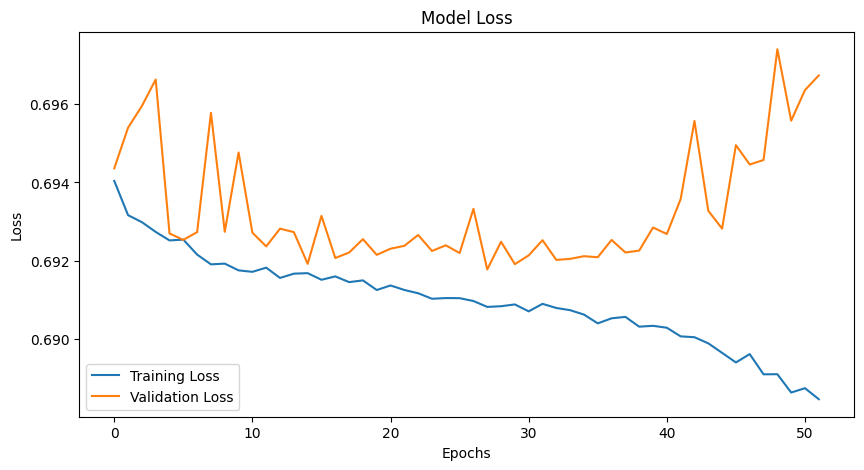

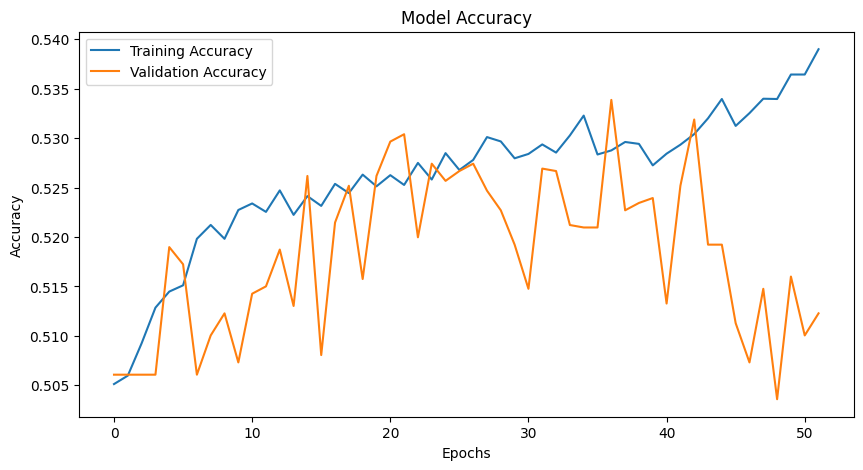

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy: 0.5202
              precision    recall  f1-score   support

           0       0.56      0.25      0.35      5118
           1       0.51      0.79      0.62      4975

    accuracy                           0.52     10093
   macro avg       0.53      0.52      0.48     10093
weighted avg       0.53      0.52      0.48     10093

ROC-AUC Score: 0.5384


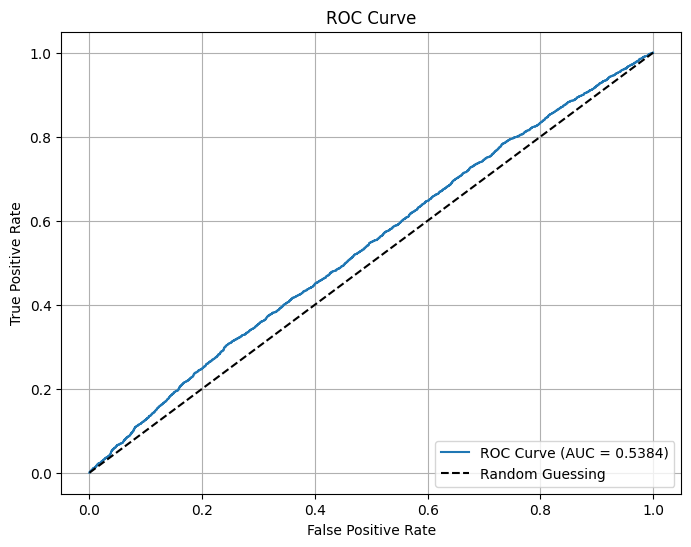

In [17]:
# Zaman penceresi boyutu
window_size = 10

# Eğitim ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, window_size)

# Model oluşturma
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

# Compiling the model
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# LSTM modelinizin tahminleri (örnek)
# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.5).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Modeli kaydetme
model.save('model7.keras')


Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


569/569 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5083 - loss: 0.6942 - val_accuracy: 0.5061 - val_loss: 0.7031
Epoch 2/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5094 - loss: 0.6934 - val_accuracy: 0.5061 - val_loss: 0.6946
Epoch 3/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5048 - loss: 0.6931 - val_accuracy: 0.5061 - val_loss: 0.6976
Epoch 4/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5056 - loss: 0.6932 - val_accuracy: 0.5061 - val_loss: 0.6998
Epoch 5/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5097 - loss: 0.6932 - val_accuracy: 0.5153 - val_loss: 0.6926
Epoch 6/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5142 - loss: 0.6926 - val_accuracy: 0.5291 - val_loss: 0.6924
Epoch 7/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5127 - loss: 0.6928 - val_accuracy: 0.5061 - val_loss: 0.6952
Epoch 8/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5208 - loss: 0.6923 - val_

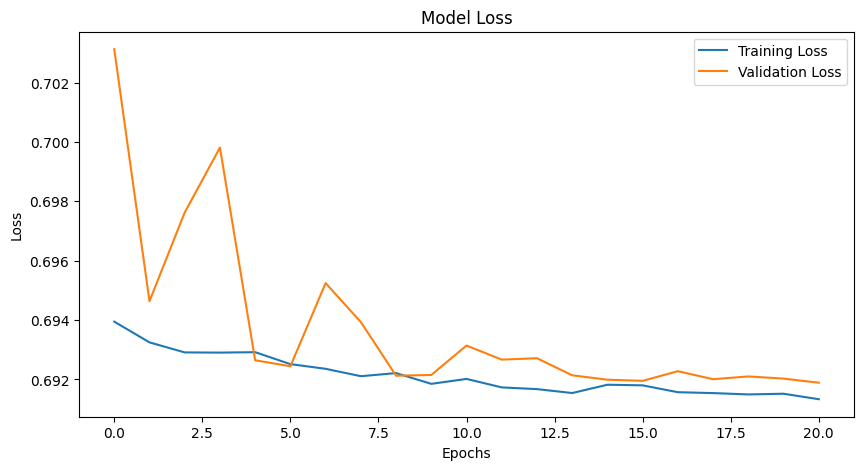

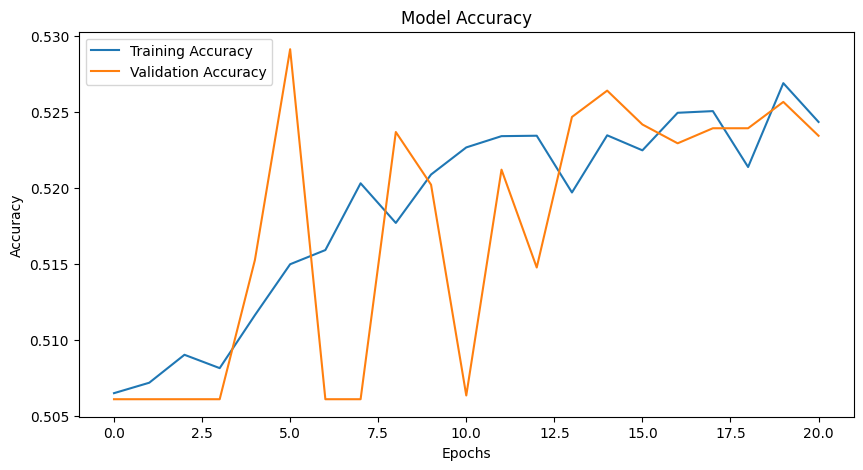

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy: 0.5187
              precision    recall  f1-score   support

           0       0.54      0.35      0.42      5118
           1       0.51      0.69      0.59      4975

    accuracy                           0.52     10093
   macro avg       0.52      0.52      0.51     10093
weighted avg       0.52      0.52      0.50     10093

ROC-AUC Score: 0.5368


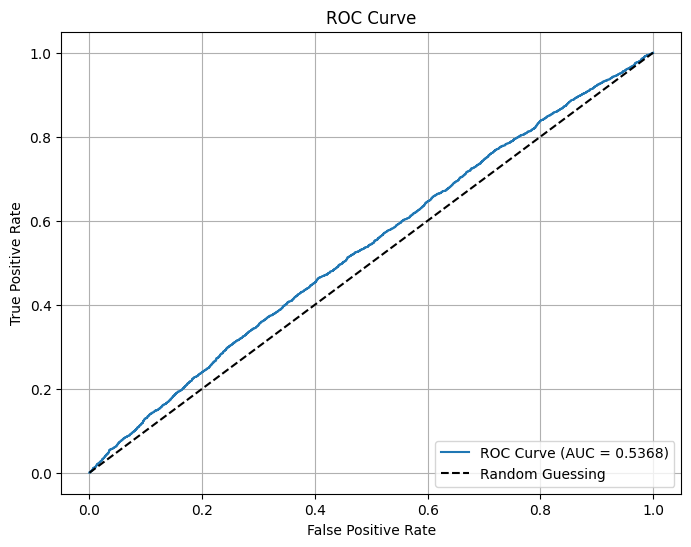

In [18]:
# Zaman penceresi boyutu
window_size = 10

# Eğitim ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, window_size)

# Model oluşturma
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

# Compiling the model
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# LSTM modelinizin tahminleri (örnek)
# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.5).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Modeli kaydetme
model.save('model8.keras')


Epoch 1/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5023 - loss: 0.7710 - val_accuracy: 0.5162 - val_loss: 0.6931
Epoch 2/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4975 - loss: 0.7099 - val_accuracy: 0.4952 - val_loss: 0.6945
Epoch 3/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5047 - loss: 0.7019 - val_accuracy: 0.4939 - val_loss: 0.6971
Epoch 4/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5043 - loss: 0.6991 - val_accuracy: 0.5061 - val_loss: 0.6935
Epoch 5/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5057 - loss: 0.6983 - val_accuracy: 0.5108 - val_loss: 0.6927
Epoch 6/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5000 - loss: 0.6997 - val_accuracy: 0.5061 - val_loss: 0.7076
Epoch 7/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5013 - loss: 0.6978 - val_accuracy: 0.4939 - val_loss: 0.6961
Epoch 8/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5083 - loss: 0

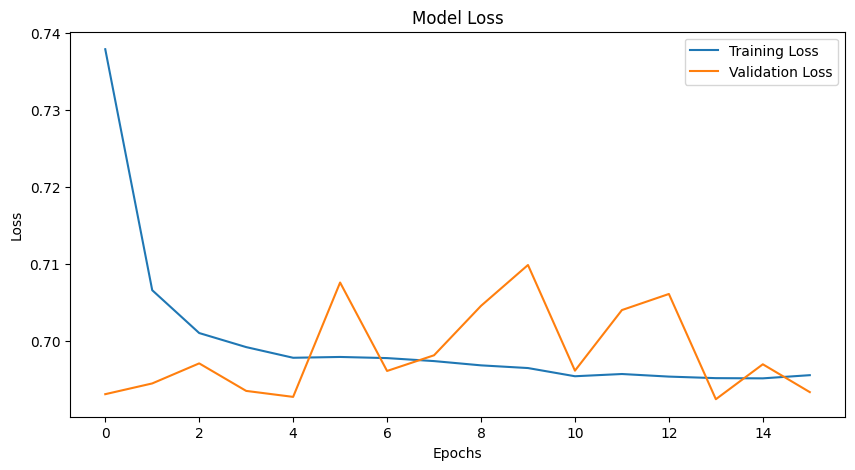

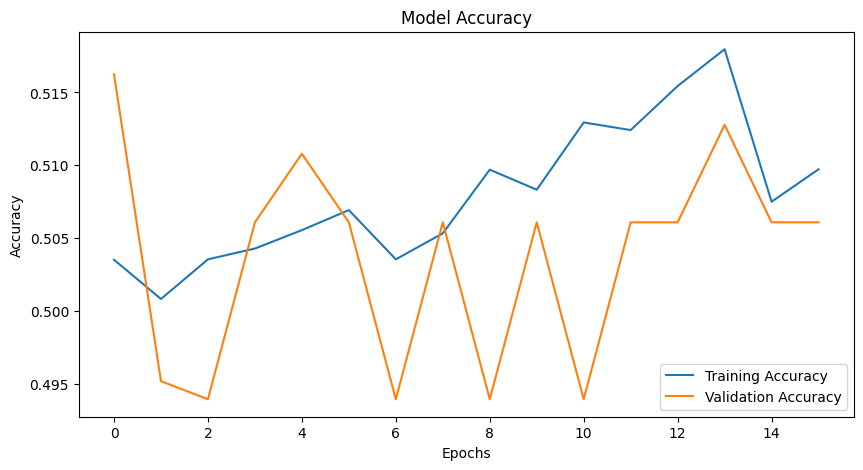

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy: 0.5204
              precision    recall  f1-score   support

           0       0.52      0.59      0.56      5118
           1       0.52      0.44      0.48      4975

    accuracy                           0.52     10093
   macro avg       0.52      0.52      0.52     10093
weighted avg       0.52      0.52      0.52     10093

ROC-AUC Score: 0.5306


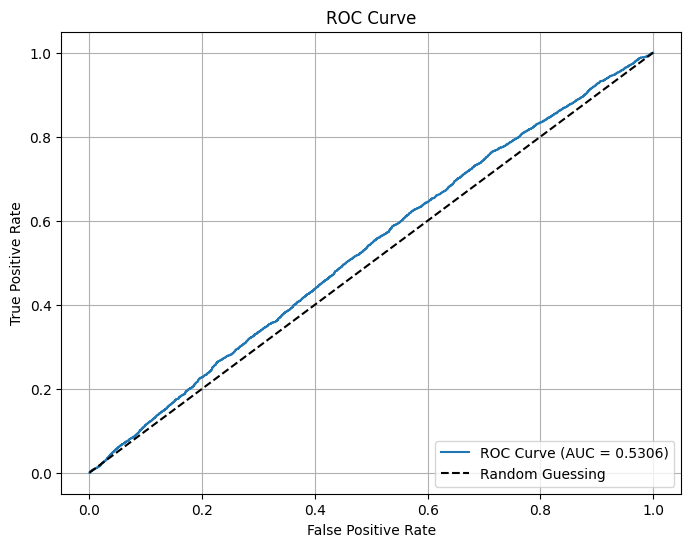

In [20]:

# Model oluşturma
model = Sequential()

# İlk LSTM katmanı
model.add(LSTM(128, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(BatchNormalization())  # BatchNormalization ekledik
model.add(Dropout(0.4))

# İkinci LSTM katmanı
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(BatchNormalization())  # BatchNormalization ekledik
model.add(Dropout(0.4))

# Tam bağlı (dense) katman
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())  # BatchNormalization ekledik
# Çıkış katmanı
model.add(Dense(1, activation='sigmoid'))

# Modeli derleme
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping ekleme
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Modeli eğitme
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.5).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Modeli kaydetme
model.save('model9.keras')

Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


569/569 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.5050 - loss: 0.6958 - val_accuracy: 0.4939 - val_loss: 0.6937
Epoch 2/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.4973 - loss: 0.6938 - val_accuracy: 0.5061 - val_loss: 0.6933
Epoch 3/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5016 - loss: 0.6944 - val_accuracy: 0.5061 - val_loss: 0.6942
Epoch 4/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5004 - loss: 0.6938 - val_accuracy: 0.5061 - val_loss: 0.7287
Epoch 5/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5016 - loss: 0.6946 - val_accuracy: 0.5061 - val_loss: 0.6969
Epoch 6/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5085 - loss: 0.6938 - val_accuracy: 0.4939 - val_loss: 0.6937
Epoch 7/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5026 - loss: 0.6939 - val_accuracy: 0.5061 - val_loss: 0.6934
Epoch 8/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5081 - loss: 0.6939 - val_

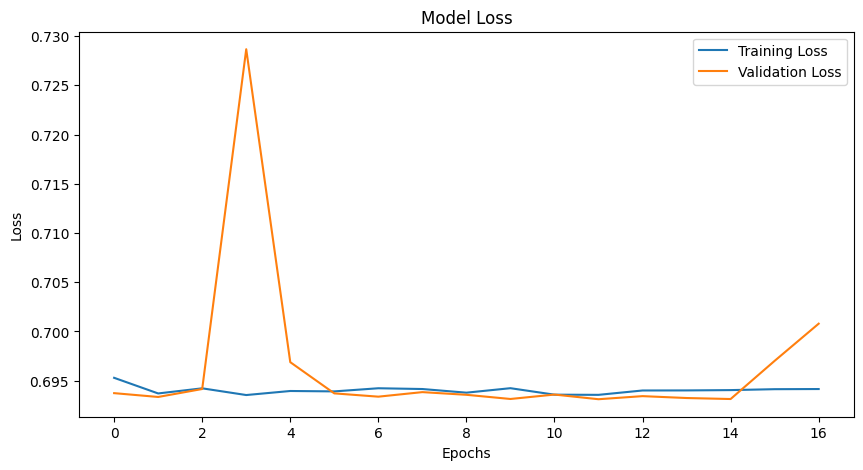

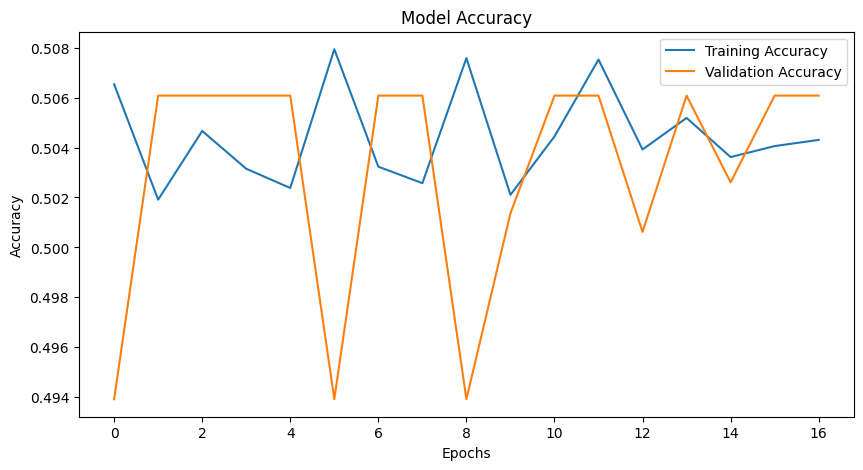

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy: 0.4929
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5118
           1       0.49      1.00      0.66      4975

    accuracy                           0.49     10093
   macro avg       0.25      0.50      0.33     10093
weighted avg       0.24      0.49      0.33     10093

ROC-AUC Score: 0.5080


c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


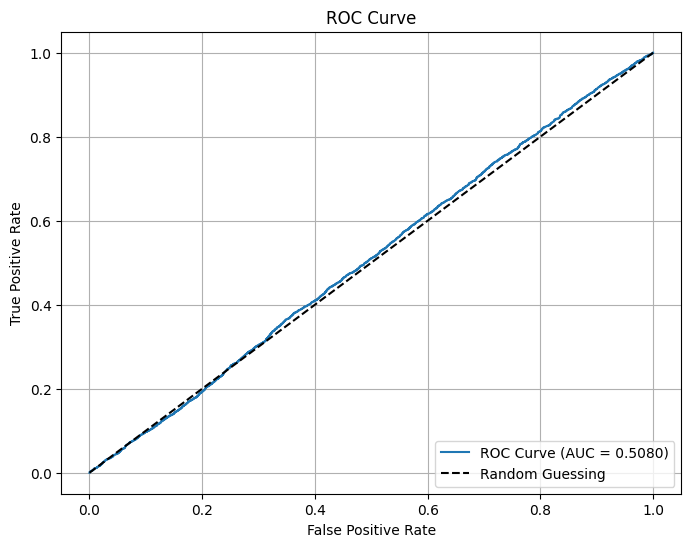

In [ ]:
# Zaman penceresi boyutu
window_size = 10

# Eğitim ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, window_size)

# Model oluşturma
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

# Compiling the model
optimizer = SGD(learning_rate=0.1, momentum=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# LSTM modelinizin tahminleri (örnek)
# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.5).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Modeli kaydetme
model.save('model10.keras')


Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


569/569 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5029 - loss: 0.6937 - val_accuracy: 0.5061 - val_loss: 0.6939
Epoch 2/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5041 - loss: 0.6935 - val_accuracy: 0.5061 - val_loss: 0.6986
Epoch 3/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5027 - loss: 0.6937 - val_accuracy: 0.5061 - val_loss: 0.6939
Epoch 4/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5069 - loss: 0.6929 - val_accuracy: 0.5170 - val_loss: 0.6929
Epoch 5/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5044 - loss: 0.6934 - val_accuracy: 0.5061 - val_loss: 0.6953
Epoch 6/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5101 - loss: 0.6930 - val_accuracy: 0.5061 - val_loss: 0.6935
Epoch 7/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5117 - loss: 0.6929 - val_accuracy: 0.4981 - val_loss: 0.6932
Epoch 8/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5069 - loss: 0.6932 - val_

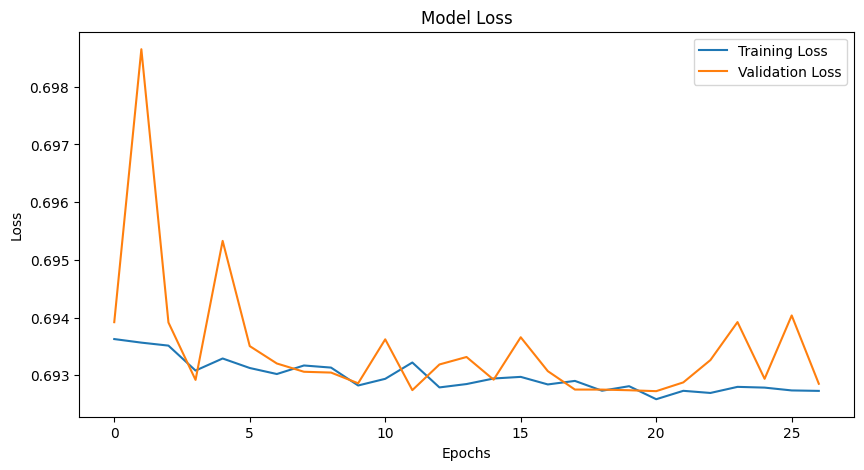

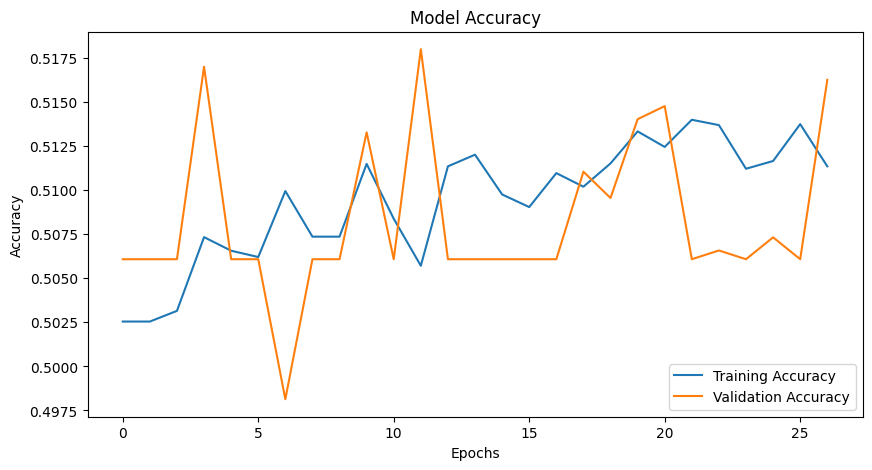

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy: 0.4953
              precision    recall  f1-score   support

           0       0.66      0.01      0.02      5118
           1       0.49      0.99      0.66      4975

    accuracy                           0.50     10093
   macro avg       0.58      0.50      0.34     10093
weighted avg       0.58      0.50      0.34     10093

ROC-AUC Score: 0.5288


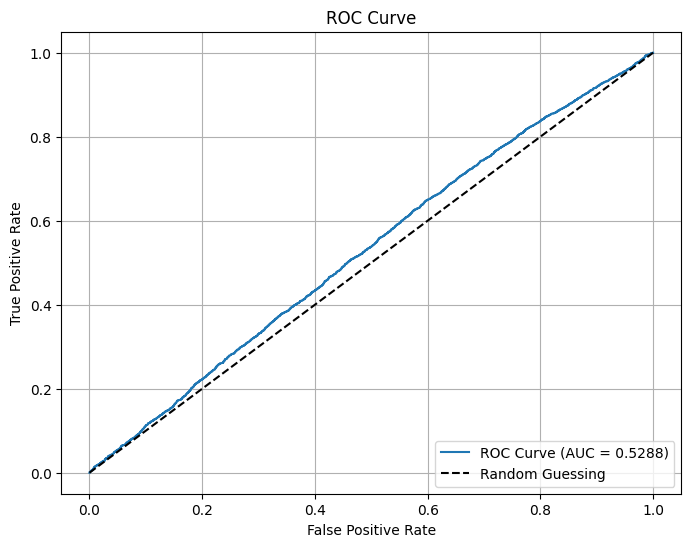

In [23]:
# Zaman penceresi boyutu
window_size = 10

# Eğitim ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, window_size)

# Model oluşturma
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

# Compiling the model
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# LSTM modelinizin tahminleri (örnek)
# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.5).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Modeli kaydetme
model.save('model10.keras')


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5062 - loss: 0.6931 - val_accuracy: 0.5062 - val_loss: 0.6936
Epoch 2/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 28s 49ms/step - accuracy: 0.5066 - loss: 0.6930 - val_accuracy: 0.5062 - val_loss: 0.6930
Epoch 3/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5048 - loss: 0.6931 - val_accuracy: 0.5198 - val_loss: 0.6927
Epoch 4/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5139 - loss: 0.6927 - val_accuracy: 0.5050 - val_loss: 0.6928
Epoch 5/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5062 - loss: 0.6928 - val_accuracy: 0.5146 - val_loss: 0.6927
Epoch 6/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.5095 - loss: 0.6929 - val_accuracy: 0.5057 - val_loss: 0.6933
Epoch 7/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.5113 - loss: 0.6926 - val_accuracy: 0.5203 - val_loss: 0.6924
Epoch 8/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.5179 - loss: 0

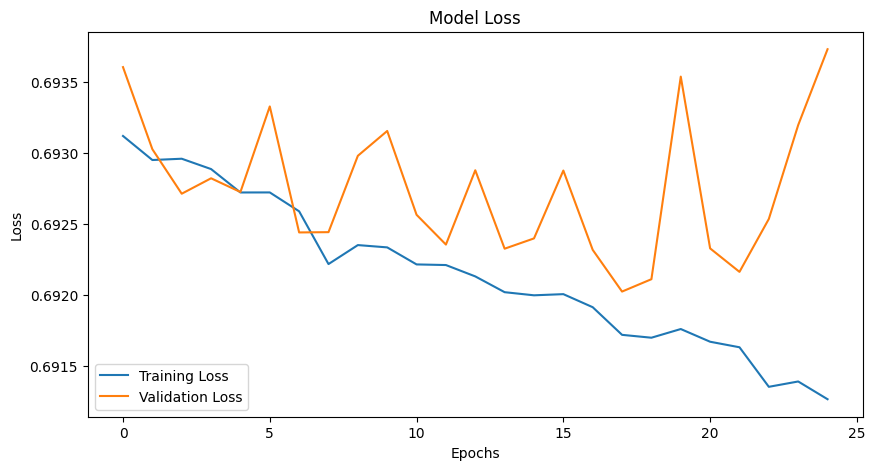

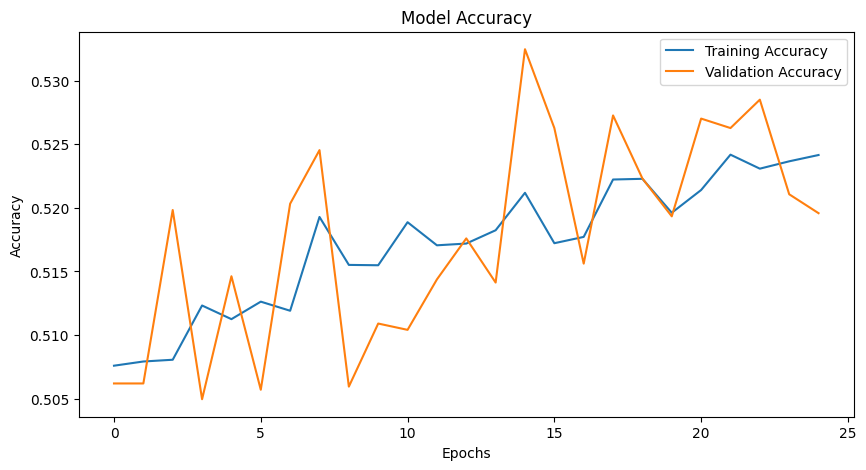

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.5146
              precision    recall  f1-score   support

           0       0.56      0.21      0.30      5122
           1       0.50      0.83      0.63      4976

    accuracy                           0.51     10098
   macro avg       0.53      0.52      0.47     10098
weighted avg       0.53      0.51      0.46     10098

ROC-AUC Score: 0.5310


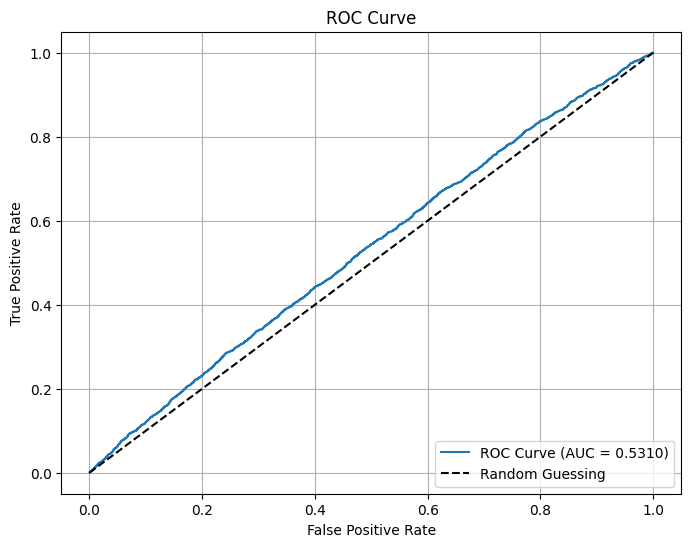

In [10]:
# Zaman penceresi boyutu
window_size = 5

# Eğitim ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, window_size)

# Model oluşturma
model = Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

# Compiling the model
optimizer = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# LSTM modelinizin tahminleri (örnek)
# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.5).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Modeli kaydetme
model.save('model5.keras')


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.5043 - loss: 0.6935 - val_accuracy: 0.5061 - val_loss: 0.6957
Epoch 2/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.5002 - loss: 0.6937 - val_accuracy: 0.5061 - val_loss: 0.6939
Epoch 3/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.5124 - loss: 0.6928 - val_accuracy: 0.5061 - val_loss: 0.6956
Epoch 4/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.5111 - loss: 0.6931 - val_accuracy: 0.5051 - val_loss: 0.6929
Epoch 5/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.5168 - loss: 0.6926 - val_accuracy: 0.5046 - val_loss: 0.6928
Epoch 6/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.5151 - loss: 0.6929 - val_accuracy: 0.4934 - val_loss: 0.6937
Epoch 7/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.5133 - loss: 0.6927 - val_accuracy: 0.5063 - val_loss: 0.6930
Epoch 8/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.5118 - loss: 0

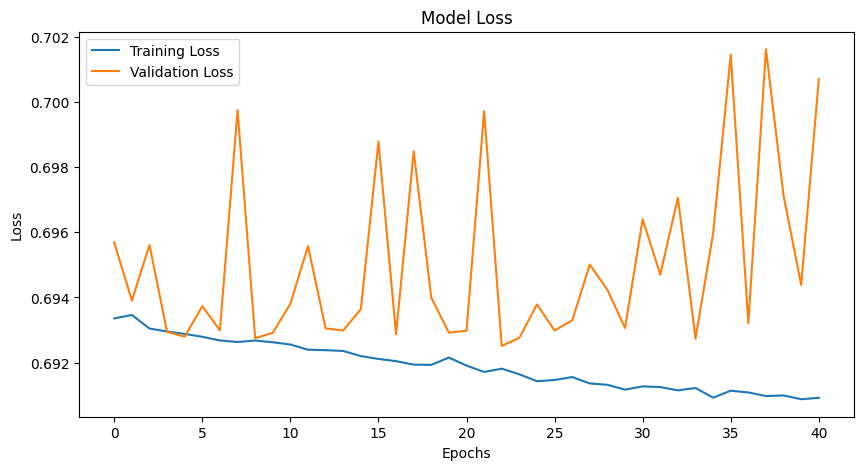

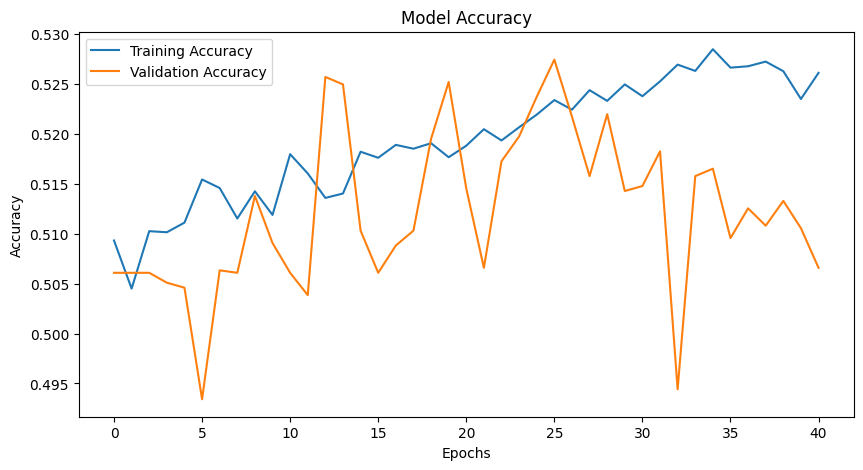

316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Accuracy: 0.5039
              precision    recall  f1-score   support

           0       0.56      0.10      0.17      5118
           1       0.50      0.92      0.65      4975

    accuracy                           0.50     10093
   macro avg       0.53      0.51      0.41     10093
weighted avg       0.53      0.50      0.40     10093

ROC-AUC Score: 0.5367


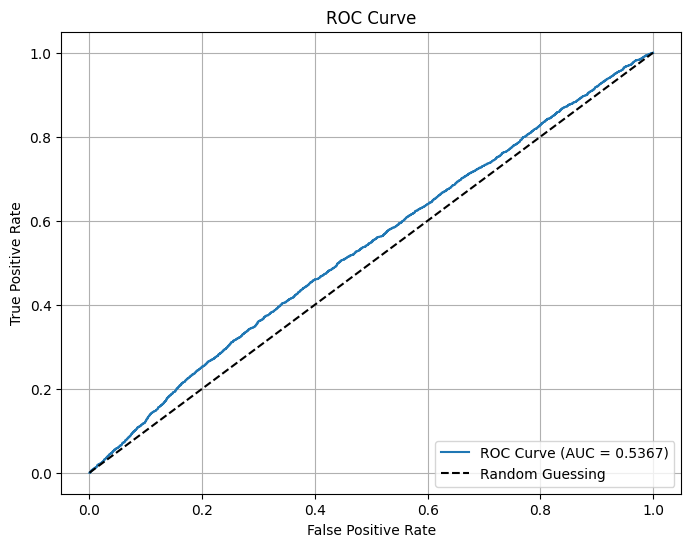

In [33]:
# Zaman penceresi boyutu
window_size = 10

# Eğitim ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, window_size)

# Model oluşturma
model = Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

# Compiling the model
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# LSTM modelinizin tahminleri (örnek)
# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.5).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Modeli kaydetme
model.save('model6.keras')


In [ ]:
# Zaman penceresi boyutu
window_size = 5

# Eğitim ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, window_size)

# Model oluşturma
model = Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

# Compiling the model
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# LSTM modelinizin tahminleri (örnek)
# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.5).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Modeli kaydetme
model.save('model7.keras')


Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


569/569 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.5027 - loss: 0.6935 - val_accuracy: 0.5094 - val_loss: 0.6929
Epoch 2/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.5120 - loss: 0.6929 - val_accuracy: 0.5062 - val_loss: 0.6939
Epoch 3/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5085 - loss: 0.6929 - val_accuracy: 0.5062 - val_loss: 0.6934
Epoch 4/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5097 - loss: 0.6930 - val_accuracy: 0.5062 - val_loss: 0.6936
Epoch 5/150
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5126 - loss: 0.6924 - val_accuracy: 0.5144 - val_loss: 0.6926
Epoch 6/150
264/569 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5228 - loss: 0.6922